<a href="https://colab.research.google.com/github/niplessa/Thesis_Data-mining-study-on-medical-and-sociological-Data-regarding-Covid19/blob/code/NLP1_International_Articles_topic_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## English Articles clustering & Topic Labeling




In [ ]:
#import libraries

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 40000)
pd.set_option('display.max_columns', 600)
pd.set_option('display.width', 3000)
pd.set_option('display.max_colwidth', 50)

import  matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import regexp_tokenize 
from string import punctuation
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

import re

import string
from string import punctuation

stopwords_eng = stopwords.words('english')
#stopwords_gr = stopwords.words('greek')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
'''#mount google drive
from google.colab import drive
drive.mount('/content/drive')

## Import NRC Lexicon
lexicon_path = "/content/drive/My Drive/datasets/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"
lex_df = pd.read_csv(lexicon_path,  names=["word", "emotion", "association"], skiprows=45, sep='\t')
lex_df.head()'''

'#mount google drive\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\n\n## Import NRC Lexicon\nlexicon_path = "/content/drive/My Drive/datasets/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt"\nlex_df = pd.read_csv(lexicon_path,  names=["word", "emotion", "association"], skiprows=45, sep=\'\t\')\nlex_df.head()'

##Preproccessing

- For the articles scraped in spring 2020 use $path\_string$
- For the autumn articles use $path\_autumn$

In [ ]:
path_spring = "https://raw.githubusercontent.com/niplessa/Datasets/main/rss_feed_english_spring.csv"
path_autumn = "https://raw.githubusercontent.com/niplessa/Datasets/main/rss_feed_english%20(2).csv"
data = pd.read_csv(path_autumn)

In [ ]:
data.head()

,title,date,summary,link
0,China’s Stance on Homosexuality Has Changed. I...,2020-10-28,A lawsuit brought by a student is part of an e...,https://www.nytimes.com/2020/10/28/business/in...
1,"As Tanzania Votes, Many See Democracy Itself o...",2020-10-28,The Tanzanian president is nicknamed “the Bull...,https://www.nytimes.com/2020/10/28/world/afric...
2,Qatar 'Regrets' Airport Strip-Searches Over Ab...,2020-10-28,Women were pulled from a Qatar Airways flight ...,https://www.nytimes.com/2020/10/27/world/middl...
3,The Lockdown That Felt Like It Might Last Fore...,2020-10-28,"Melbourne, Australia’s second-largest city, em...",https://www.nytimes.com/2020/10/28/world/austr...
4,"Roots of War: When Armenia Talked Tough, Azerb...",2020-10-27,While Azerbaijan is clearly the main driver of...,https://www.nytimes.com/2020/10/27/world/europ...


In [ ]:
extra_stopwords = ['rt','article','titlesummary','buzzfeed','rsaquo','view entire',' entire post','entire','post',
                    'continue reading','reading','article',  'read','full','continue', 'latest','updates',
                   'briefinghere','briefing','briefingher','need','know','monday','tuesday','wednesday',
                   'thursday','friday','saturday','sunday']

stopwords_eng = stopwords.words('english')
stopwords_eng.extend(extra_stopwords)

In [ ]:
keywords = ["corona", "virus", "covid", "COVID", "Covid", "Covid19", "Covid-19", "SARS","Sars","lockdown",
            "measures","quarantine","virus","spread","nCov","sars","SARS","pandemic","mask","masks","vaccine"]

In [ ]:
#drop duplicate titles on original dataset
data.drop_duplicates(subset="title",keep = "first", inplace = True)
print("Total retrieved articles: ",data.shape[0])

data["summary"] = data['summary'].astype('str')
data["title"] = data['title'].astype('str')

Total retrieved articles:  5919


### Create a separate DF only with covid related articles

In [ ]:
data['text'] = data.title + data.summary

In [ ]:
corona_data = pd.DataFrame()

for k in keywords :
    tmp = data[data['text'].str.lower().str.contains(k)]
    corona_data = corona_data.append(tmp)
    
    
    
corona_data.sort_values("date", inplace = True,ascending = False)   #sort by date
corona_data.drop_duplicates(subset="title",          #drop duplicate titles
                      keep = "first", inplace = True,)
corona_data = corona_data.reset_index(drop=True) #reset index
print("Corona virus related articles: ",corona_data.shape[0])

Corona virus related articles:  1660


## NLP preproccess

In [ ]:
#lematization function
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    lemmatized = []
    for word in text:
        lemmatized.append(lemmatizer.lemmatize(word))
    return lemmatized

In [ ]:
#remove stopwords function
stops =  list(stopwords_eng)
def remove_stops(text):
    text_no_stops = []
    for i in text:
        if i not in stops:
            if len(i) == 1:
                pass
            else:
                text_no_stops.append(i)
        else:
            pass
    return text_no_stops

In [ ]:
# make all text lowercase
corona_data['text'] = corona_data['text'].apply(lambda x: x.lower())

# removing everything except alphabets
corona_data['text'] = corona_data['text'].str.replace("[^a-zA-Z]", " ")

# removing short words <3 letters length
corona_data['text'] = corona_data['text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [ ]:
# tokenization
corona_data['text_tokenized'] = corona_data['text'].apply(lambda x: regexp_tokenize(x,"[\w']+"))

#actually remove stopwords
corona_data['text_tokenized'] = corona_data['text_tokenized'].apply(lambda x: remove_stops(x))

In [ ]:
#lemmatization
corona_data['text_lemmatized'] = corona_data['text_tokenized'].apply(lemmatize_text)

In [ ]:
#stemming
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 
corona_data['text_stemmed'] = corona_data['text_lemmatized'].apply(lambda x: [ps.stem(y) for y in x])

In [ ]:
#de - tokenization
corona_data['stemmed_string'] = corona_data['text_stemmed'].apply(lambda x: ' '.join(x))
corona_data['lemmatized_string'] = corona_data['text_lemmatized'].apply(lambda x: ' '.join(x))

In [ ]:
#inspect the dataframe
corona_data.head()

,title,date,summary,link,text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string
0,The Trump Administration Is Considering Exclud...,2020-9-9,"“On first glance, this revised order seems mo...",https://www.buzzfeednews.com/article/hamedalea...,trump administration considering excluding som...,"[trump, administration, considering, excluding...","[trump, administration, considering, excluding...","[trump, administr, consid, exclud, immigr, chi...",trump administr consid exclud immigr child con...,trump administration considering excluding imm...
1,These Scientists Are Still Studying The World’...,2020-8-29,Scientists launched clinical trials to see if...,https://www.buzzfeednews.com/article/stephanie...,these scientists still studying world most con...,"[scientists, still, studying, world, controver...","[scientist, still, studying, world, controvers...","[scientist, still, studi, world, controversi, ...",scientist still studi world controversi drug f...,scientist still studying world controversial d...
2,New Zealand Lawmakers Are Hitting Back At Trum...,2020-8-19,"On Monday, the US recorded almost 38,000 new ...",https://www.buzzfeednews.com/article/davidmack...,zealand lawmakers hitting back trump comments ...,"[zealand, lawmakers, hitting, back, trump, com...","[zealand, lawmaker, hitting, back, trump, comm...","[zealand, lawmak, hit, back, trump, comment, c...",zealand lawmak hit back trump comment coronavi...,zealand lawmaker hitting back trump comment co...
3,How A 4th Of July Meal Exposes The Coronavirus...,2020-7-6,Hundreds of workers may have contracted COVID...,https://www.buzzfeednews.com/article/albertsam...,july meal exposes coronavirus risk thousands f...,"[july, meal, exposes, coronavirus, risk, thous...","[july, meal, expose, coronavirus, risk, thousa...","[juli, meal, expos, coronaviru, risk, thousand...",juli meal expos coronaviru risk thousand food ...,july meal expose coronavirus risk thousand foo...
4,They Lost Their Loved Ones To COVID-19. Then T...,2020-7-3,“I feel humiliated. We were doubly hit: not g...,https://www.buzzfeednews.com/article/karlazabl...,they lost their loved ones covid then governme...,"[lost, loved, ones, covid, government, lost, r...","[lost, loved, one, covid, government, lost, re...","[lost, love, one, covid, govern, lost, remain,...",lost love one covid govern lost remain feel hu...,lost loved one covid government lost remains f...


##WordCloud

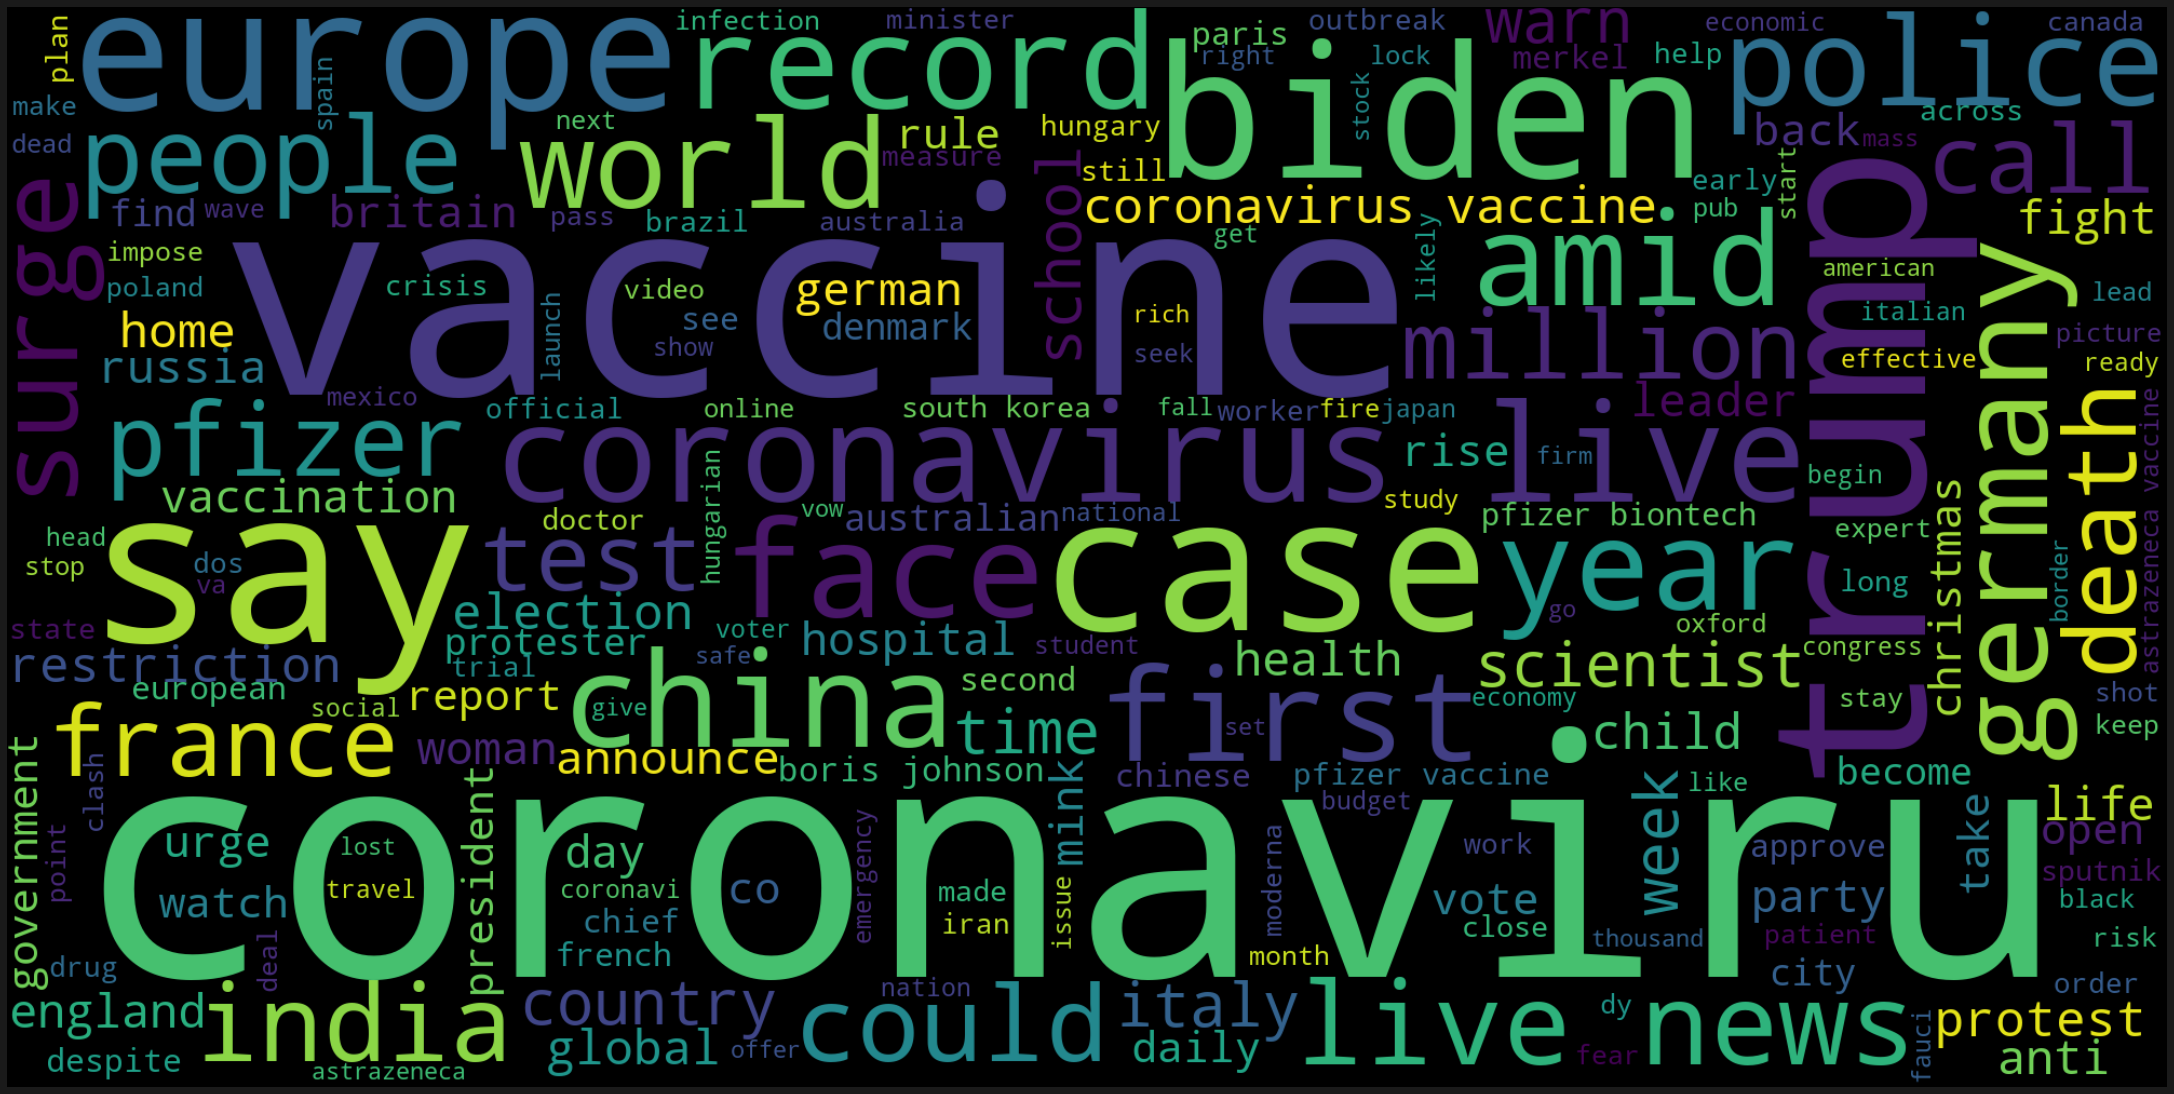

In [ ]:
text = corona_data.lemmatized_string
wordcloud = WordCloud(
    width = 2000,
    height = 1000,
    background_color = 'black',
    stopwords = stopwords_eng+keywords).generate(str(text))
fig = plt.figure(
    figsize = (30, 20),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##TFIDF vectorizer

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords_eng, 
max_features= 1000, # keep top 1000 terms
max_df=0.3, 
min_df = 10, 
smooth_idf=True,
use_idf = True,
ngram_range=(1,2))

#vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,2))

 
X = vectorizer.fit_transform(corona_data['lemmatized_string'])
terms = vectorizer.get_feature_names()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['view'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


#Τopic Labeling
Find most frequent topics in the articles

##K-means Clustering

In [ ]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 15

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


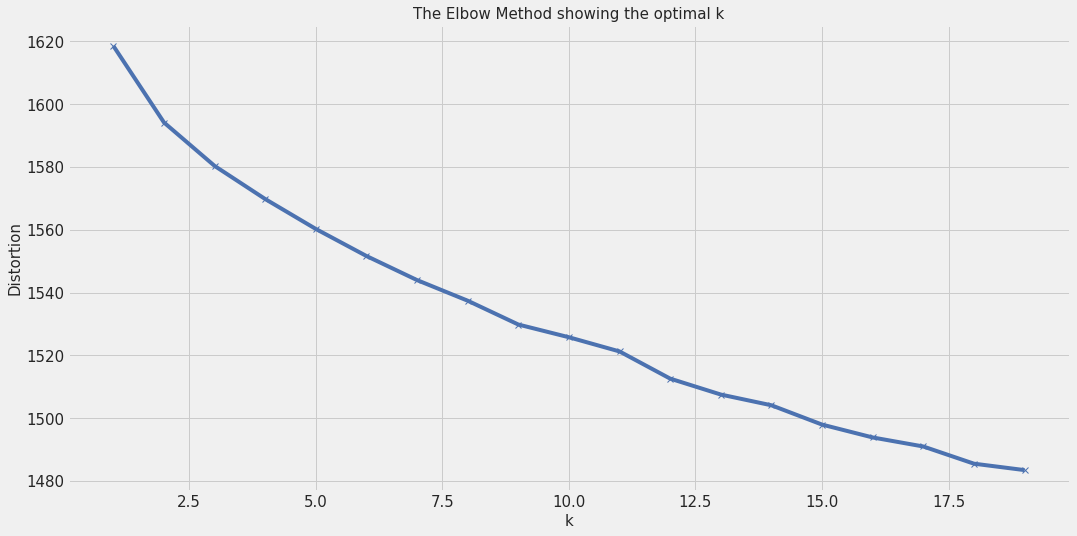

In [ ]:
#elbow method
distortions = []
K = range(1,20)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
num_clusters = 9

km = KMeans(n_clusters=num_clusters,init='k-means++', max_iter=100, n_init=10, random_state=1)

labels = km.fit_predict(X)

In [ ]:
#most important n-gramms (words) in each cluster

print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s,' % terms[ind])
    print('\n')


K-means clustering: 

Cluster 0:
 pandemic,
 year,
 world,
 coronavirus pandemic,
 people,
 child,
 global,
 china,
 home,
 time,


Cluster 1:
 vaccine,
 covid vaccine,
 pfizer,
 coronavirus vaccine,
 trial,
 biontech,
 first,
 pfizer biontech,
 approval,
 astrazeneca,


Cluster 2:
 health,
 hospital,
 wave,
 patient,
 second,
 covid patient,
 doctor,
 india,
 second wave,
 care,


Cluster 3:
 lockdown,
 restriction,
 france,
 christmas,
 germany,
 minister,
 country,
 england,
 school,
 rule,


Cluster 4:
 virus,
 test,
 positive,
 mink,
 tested,
 denmark,
 tested positive,
 else,
 infected,
 cull,


Cluster 5:
 police,
 protester,
 protest,
 lockdown,
 anti,
 party,
 clash,
 anti lockdown,
 video,
 arrest,


Cluster 6:
 mask,
 wearing,
 wear,
 wear mask,
 face,
 wearing mask,
 american,
 biden,
 face mask,
 say,


Cluster 7:
 case,
 record,
 covid case,
 death,
 coronavirus case,
 daily,
 surge,
 country,
 infection,
 rise,


Cluster 8:
 trump,
 biden,
 election,
 president,
 donald,

In [ ]:
corona_data['cluster'] = labels

##Visualize Clusters Size





In [ ]:
import seaborn as sns
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')

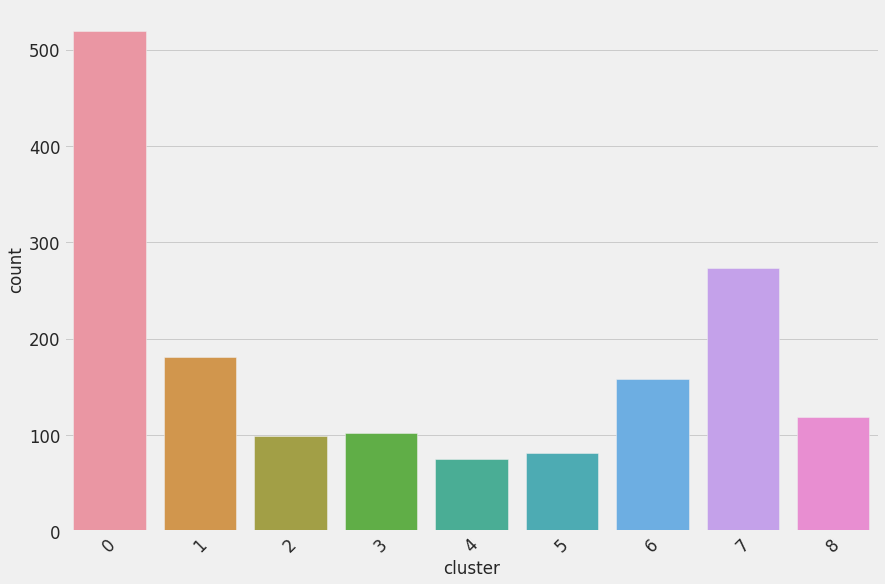

In [ ]:
sns.set(font_scale = 1.5)
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='cluster', data=corona_data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

## Most important N-grams


In [ ]:
from nltk import trigrams
from nltk import bigrams
from collections import Counter

print('Top Bigrams')
for i in range(num_clusters):
  L = [x for x in corona_data[corona_data['cluster']==i].lemmatized_string for x in bigrams(x.split())]
  c = Counter(L)
  top = c.most_common(5)
  print("\n Cluster: ",i)
  print (top)
  print('\n')

print('Top Trigrams')
for i in range(num_clusters):
  L = [x for x in corona_data[corona_data['cluster']==i].lemmatized_string for x in trigrams(x.split())]
  c = Counter(L)
  top = c.most_common(5)
  print("\n Cluster: ",i)
  print (top)
  print('\n')


Top Bigrams

 Cluster:  0
[(('coronavirus', 'coronavirus'), 37), (('coronavirus', 'coverage'), 37), (('second', 'wave'), 24), (('covid', 'patient'), 20), (('covid', 'lockdown'), 16)]



 Cluster:  1
[(('covid', 'vaccine'), 155), (('coronavirus', 'vaccine'), 65), (('coronavirus', 'coverage'), 17), (('vaccine', 'trial'), 17), (('coronavirus', 'coronavirus'), 14)]



 Cluster:  2
[(('prime', 'minister'), 38), (('boris', 'johnson'), 29), (('coronavirus', 'coronavirus'), 14), (('coronavirus', 'coverage'), 13), (('health', 'minister'), 13)]



 Cluster:  3
[(('donald', 'trump'), 50), (('president', 'elect'), 34), (('white', 'house'), 17), (('sign', 'receive'), 14), (('receive', 'first'), 13)]



 Cluster:  4
[(('pfizer', 'biontech'), 59), (('covid', 'vaccine'), 53), (('coronavirus', 'vaccine'), 31), (('biontech', 'vaccine'), 18), (('biontech', 'covid'), 18)]



 Cluster:  5
[(('anti', 'lockdown'), 19), (('covid', 'restriction'), 9), (('coronavirus', 'lockdown'), 9), (('lockdown', 'protester'

## Some articles from each cluster

In [ ]:
for i in range(0,10):
  print("\ncluster =",i)
  print('\n')
  print(corona_data[corona_data['cluster']==i].title.head(10))


cluster = 0


1     These Scientists Are Still Studying The World’...
4     They Lost Their Loved Ones To COVID-19. Then T...
5     She Had 30 Minutes To Say Goodbye To Her Dad. ...
7     A Takeout Order At KFC At 1:30 A.M. Raised Sus...
12    Asian nations ‘won’t let anyone in without a v...
15    Hungary hospital sets up 'COVID safe' booths f...
18    The world economy will be worse than expected ...
19    Group at ‘epicenter’ of German coronavirus pro...
20    Children’s hospitals are pitching in to help w...
23    Coronavirus: Merkel calls for new restrictions...
Name: title, dtype: object

cluster = 1


21             U.K. Coronavirus Vaccine Campaign Begins
27    UAE approves China’s Sinopharm vaccine, says i...
30    Rich countries ‘hoarding’ Covid-19 vaccine dos...
34    Coronavirus vaccine from China’s Sinopharm is ...
46    'V-Day': 90-year-old gets first COVID-19 jab a...
47    Coronavirus live news: 90-year-old Briton beco...
49    AstraZeneca COVID-19 vaccine around 70% e

## Sentiment Analysis

In [ ]:
from textblob import TextBlob

In [ ]:
def analyze_sentiment_class(text):
    analysis = TextBlob(text)
    #return  analysis.sentiment.polarity
    
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"

In [ ]:
def analyze_sentiment_score(text):
    analysis = TextBlob(text)
    return  analysis.sentiment.polarity
    

In [ ]:
corona_data['sentiment_class'] = np.array([ analyze_sentiment_class(article) for article in corona_data['lemmatized_string'] ])
corona_data['sentiment_score'] = np.array([ analyze_sentiment_score(article) for article in corona_data['lemmatized_string'] ])

## Plot Sentiement for each cluster


Cluster:  0




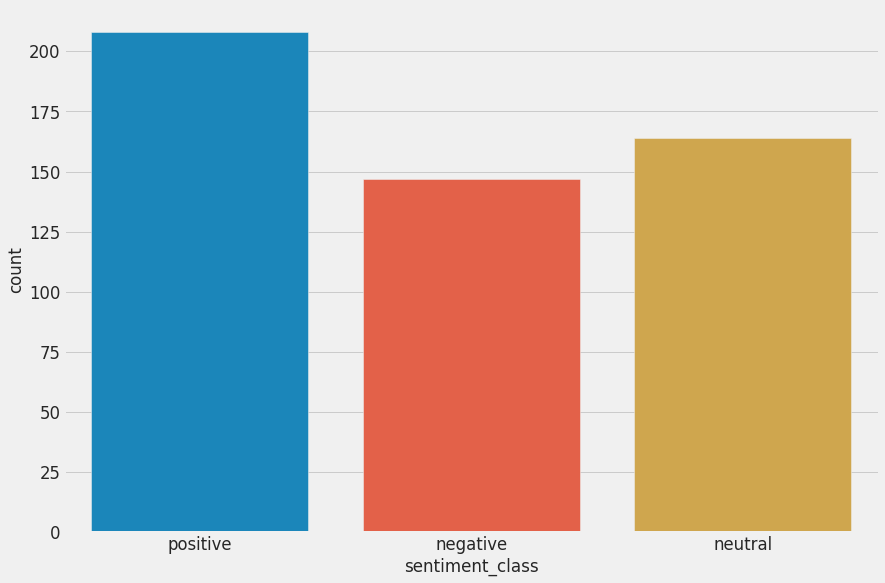


Cluster:  1




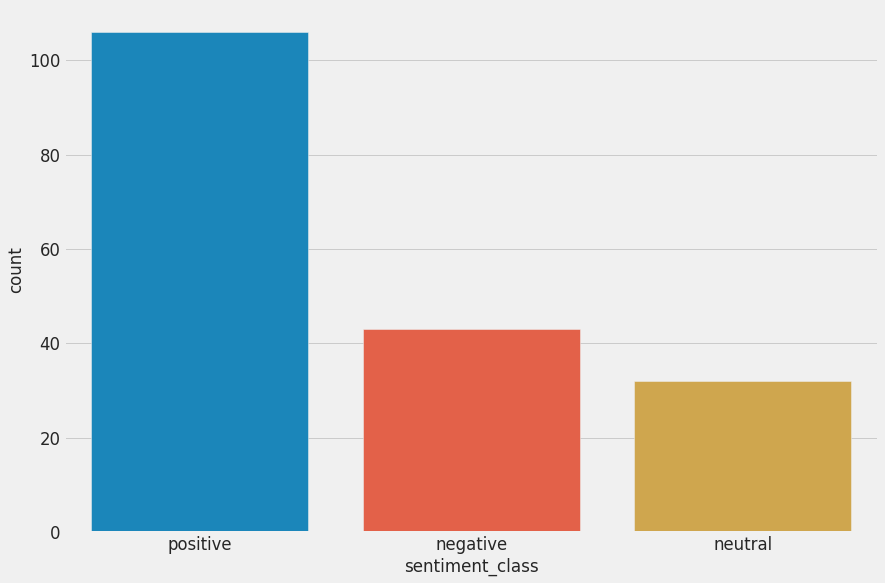


Cluster:  2




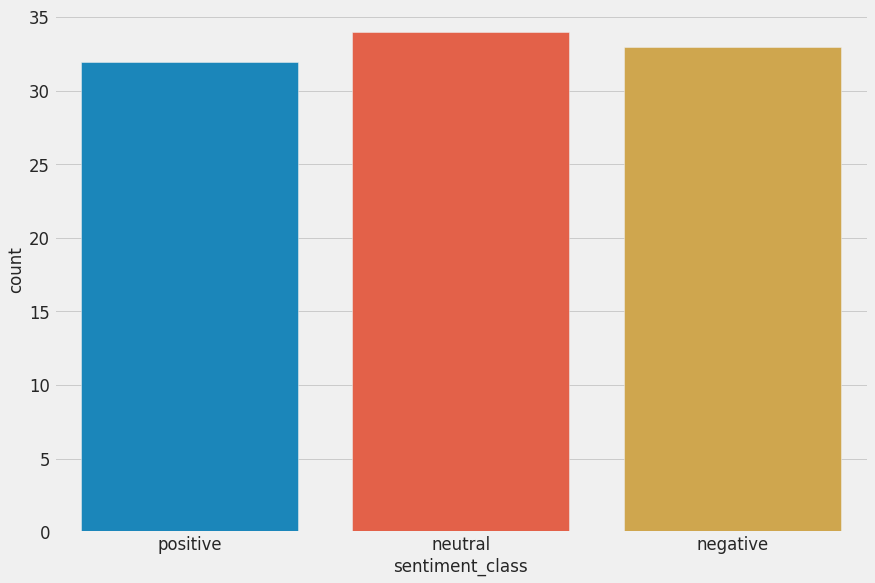


Cluster:  3




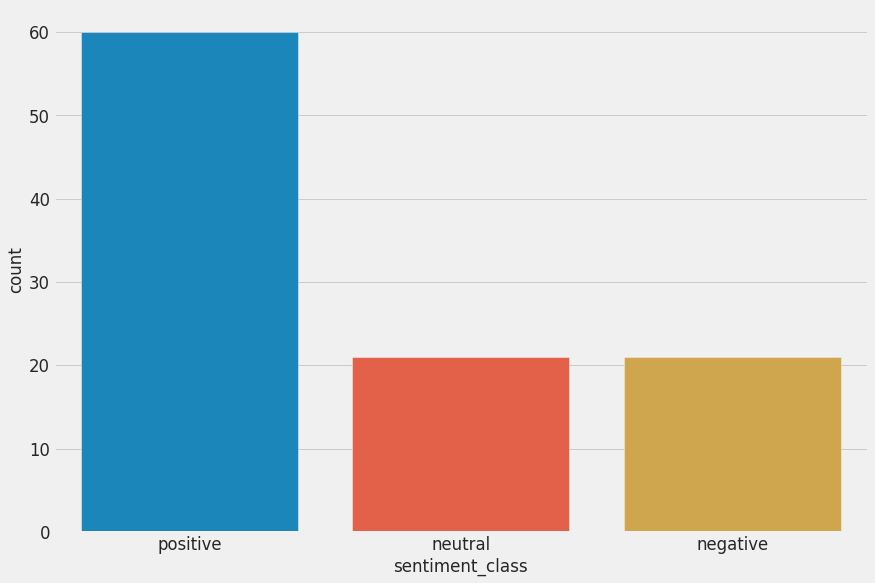


Cluster:  4




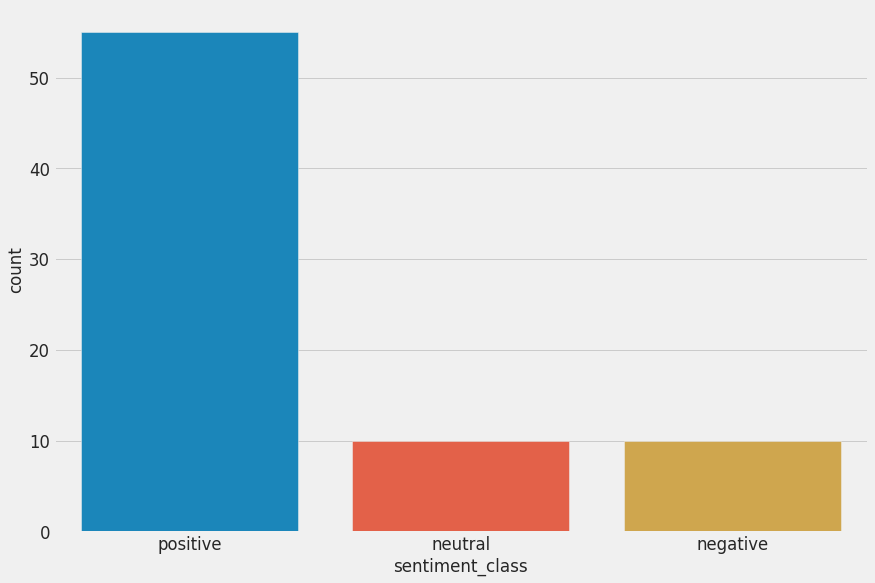


Cluster:  5




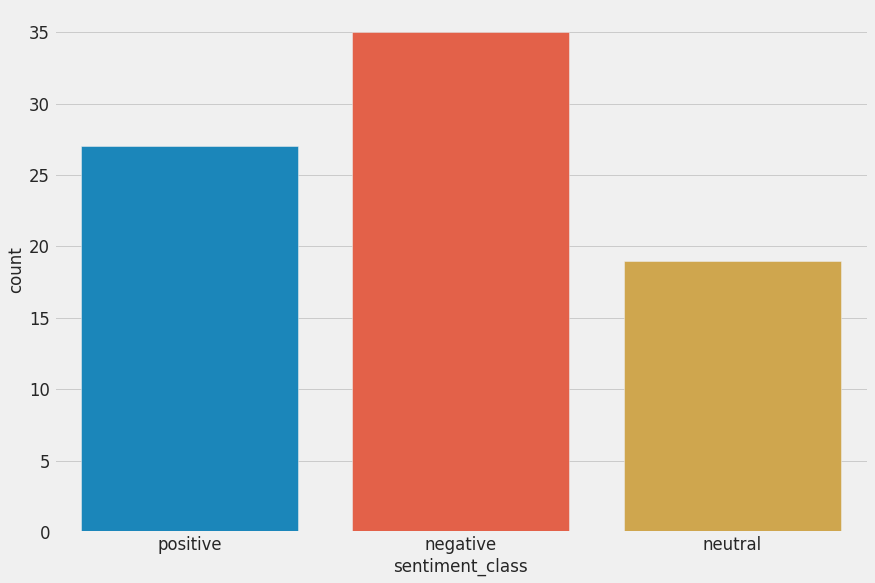


Cluster:  6




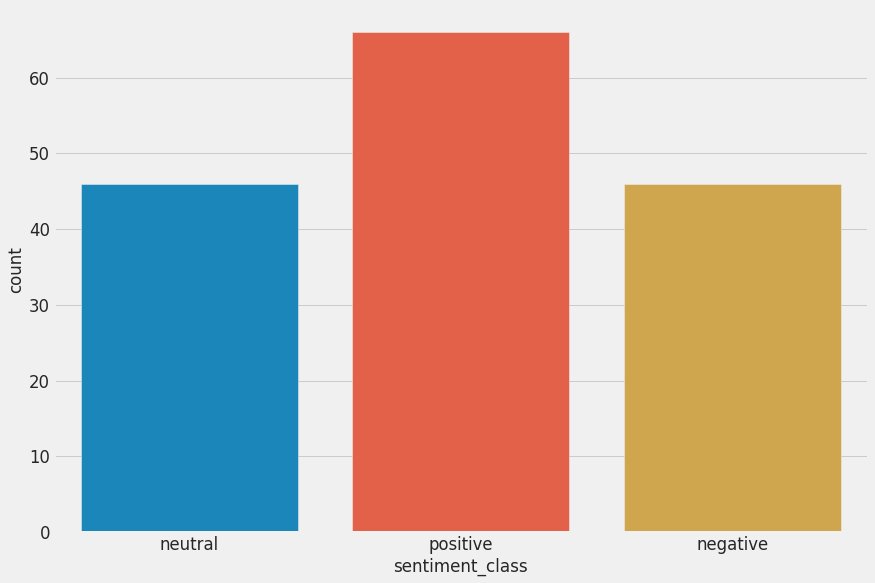

In [ ]:
for c in range (0,7):
  df=corona_data[corona_data['cluster']==c]
  print("\nCluster: ",c)
  print("\n")
  ax = sns.countplot(x= 'sentiment_class',data=df)
  plt.show()

## Plot Sentiment Results for the whole dataset

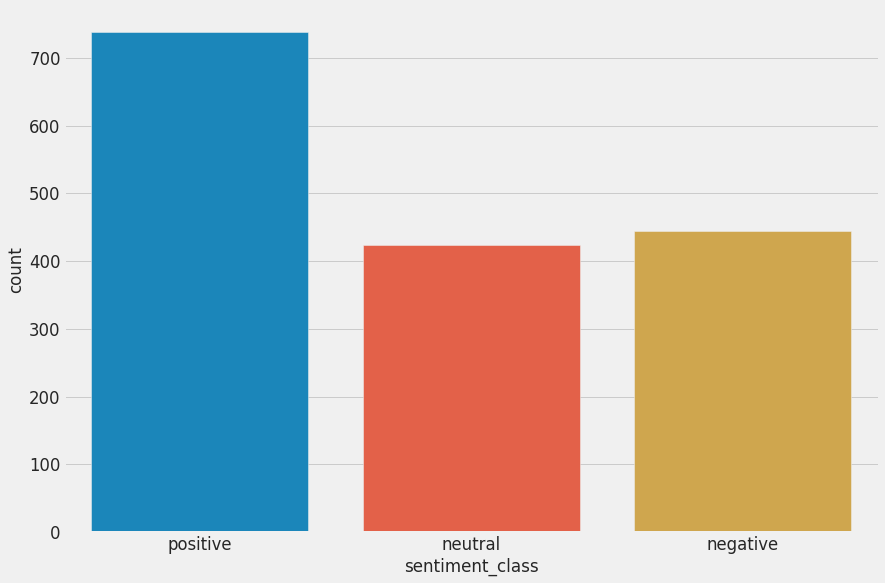

In [ ]:
ax = sns.countplot(x= 'sentiment_class', data=corona_data)
plt.show()

## Sentiment Analysis using NRC Lexicon
http://jonathansoma.com/lede/algorithms-2017/classes/more-text-analysis/nrc-emotional-lexicon/

use NRC for real data:
https://www.geeksforgeeks.org/emotion-classification-using-nrc-lexicon-in-python/

https://github.com/metalcorebear/NRCLex

In [ ]:
!pip install NRCLex
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [ ]:
from nrclex import NRCLex 
text = "You are despicable"
text_object = NRCLex(text)

#Return words list
print(text_object.words)

#Return sentences list.
print(text_object.sentences)

#Return affect list.
print(text_object.affect_list)

#Return affect dictionary.
print(text_object.affect_dict)


#Return raw emotional counts.
print(text_object.raw_emotion_scores)


#Return highest emotions.
print(text_object.top_emotions)

print(text_object.affect_frequencies)

['You', 'are', 'despicable']
[Sentence("You are despicable")]
['anger', 'disgust', 'negative']
{'despicable': ['anger', 'disgust', 'negative']}
{'anger': 1, 'disgust': 1, 'negative': 1}
[('anger', 0.3333333333333333), ('negative', 0.3333333333333333), ('disgust', 0.3333333333333333)]
{'fear': 0.0, 'anger': 0.3333333333333333, 'anticip': 0.0, 'trust': 0.0, 'surprise': 0.0, 'positive': 0.0, 'negative': 0.3333333333333333, 'sadness': 0.0, 'disgust': 0.3333333333333333, 'joy': 0.0}


In [ ]:
corona_data['emotion'] = ''
corona_data['emotion_score'] = ''

In [ ]:
for i in range(0,corona_data.shape[0]):
  text = corona_data['lemmatized_string'][i]
  text_object = NRCLex(text)
  corona_data['emotion'][i] = text_object.top_emotions[0][0]
  corona_data['emotion_score'][i] = text_object.top_emotions[0][1]
  #print("\n")
  #print(text_object.words)
  #print(text_object.top_emotions)
  #print(i)
  #print("\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
for i in range(0,corona_data.shape[0]):
  text = corona_data['lemmatized_string'][i]
  text_object = NRCLex(text)
  corona_data['emotion'][i] = text_object.top_emotions[0][0]
  corona_data['emotion_score'][i] = text_object.top_emotions[0][1]
  print("\n")
  print(text_object.words)
  print(text_object.top_emotions)
  print(i)
  print("\n")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Streaming output truncated to the last 5000 lines.




['coronavirus', 'live', 'news', 'italy', 'report', 'covid', 'linked', 'death', 'gaza', 'infection', 'spiralling', 'control', 'italy', 'exceeds', 'covid', 'death', 'total', 'gaza', 'reported', 'record', 'high', 'case', 'vaccine', 'news', 'oxford', 'university', 'astrazeneca', 'oxford', 'astrazeneca', 'vaccine', 'efficacy', 'vaccine', 'sold', 'developing', 'country', 'cost', 'price', 'french', 'fined', 'breaking', 'lockdown', 'smash', 'face', 'shanghai', 'covid', 'outbreak', 'traced', 'cargo', 'north', 'america', 'coronavirus', 'live', 'nigeria', 'passenger', 'fail', 'follow', 'country', 'covid', 'protocol', 'flying', 'month', 'official', 'said', 'passenger', 'returning', 'nigeria', 'currently', 'required', 'test', 'coronavirus', 'board', 'return', 'flight', 'seven', 'day', 'arrive', 'also', 'must', 'test', 'advance', 'sani', 'aliyu', 'coordinator', 'nigeria', 'covid', 'task', 'force', 'said', 'paid', 'test', 'failed', 'show', 'passe

In [ ]:
corona_data.head()

,title,date,summary,link,text,text_tokenized,text_lemmatized,text_stemmed,stemmed_string,lemmatized_string,cluster,sentiment_class,sentiment_score,emotion,emotion_score
0,The Trump Administration Is Considering Exclud...,2020-9-9,"“On first glance, this revised order seems mo...",https://www.buzzfeednews.com/article/hamedalea...,trump administration considering excluding som...,"[trump, administration, considering, excluding...","[trump, administration, considering, excluding...","[trump, administr, consid, exclud, immigr, chi...",trump administr consid exclud immigr child con...,trump administration considering excluding imm...,7,positive,0.433333,negative,0.26087
1,These Scientists Are Still Studying The World’...,2020-8-29,Scientists launched clinical trials to see if...,https://www.buzzfeednews.com/article/stephanie...,these scientists still studying world most con...,"[scientists, still, studying, world, controver...","[scientist, still, studying, world, controvers...","[scientist, still, studi, world, controversi, ...",scientist still studi world controversi drug f...,scientist still studying world controversial d...,0,positive,0.183333,trust,0.2
2,New Zealand Lawmakers Are Hitting Back At Trum...,2020-8-19,"On Monday, the US recorded almost 38,000 new ...",https://www.buzzfeednews.com/article/davidmack...,zealand lawmakers hitting back trump comments ...,"[zealand, lawmakers, hitting, back, trump, com...","[zealand, lawmaker, hitting, back, trump, comm...","[zealand, lawmak, hit, back, trump, comment, c...",zealand lawmak hit back trump comment coronavi...,zealand lawmaker hitting back trump comment co...,6,neutral,0.000000,fear,0.285714
3,How A 4th Of July Meal Exposes The Coronavirus...,2020-7-6,Hundreds of workers may have contracted COVID...,https://www.buzzfeednews.com/article/albertsam...,july meal exposes coronavirus risk thousands f...,"[july, meal, exposes, coronavirus, risk, thous...","[july, meal, expose, coronavirus, risk, thousa...","[juli, meal, expos, coronaviru, risk, thousand...",juli meal expos coronaviru risk thousand food ...,july meal expose coronavirus risk thousand foo...,7,neutral,0.000000,anticipation,0.266667
4,They Lost Their Loved Ones To COVID-19. Then T...,2020-7-3,“I feel humiliated. We were doubly hit: not g...,https://www.buzzfeednews.com/article/karlazabl...,they lost their loved ones covid then governme...,"[lost, loved, ones, covid, government, lost, r...","[lost, loved, one, covid, government, lost, re...","[lost, love, one, covid, govern, lost, remain,...",lost love one covid govern lost remain feel hu...,lost loved one covid government lost remains f...,0,positive,0.233333,negative,0.235294


## Plot emotions 

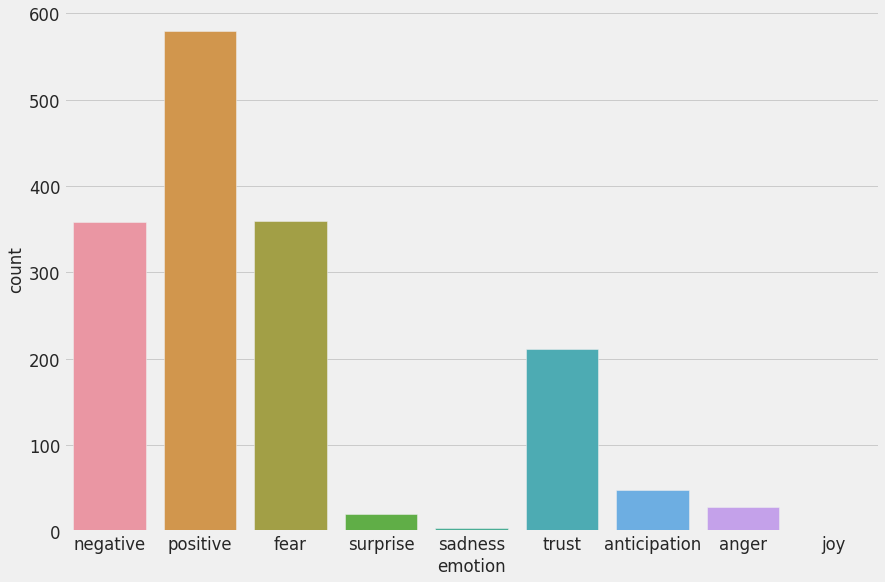

In [ ]:
ax = sns.countplot(x= 'emotion',data=corona_data, order=['negative', 'positive', 'fear', 'surprise', 'sadness','trust','anticipation','anger', 'joy'])
plt.show()


Cluster:  0




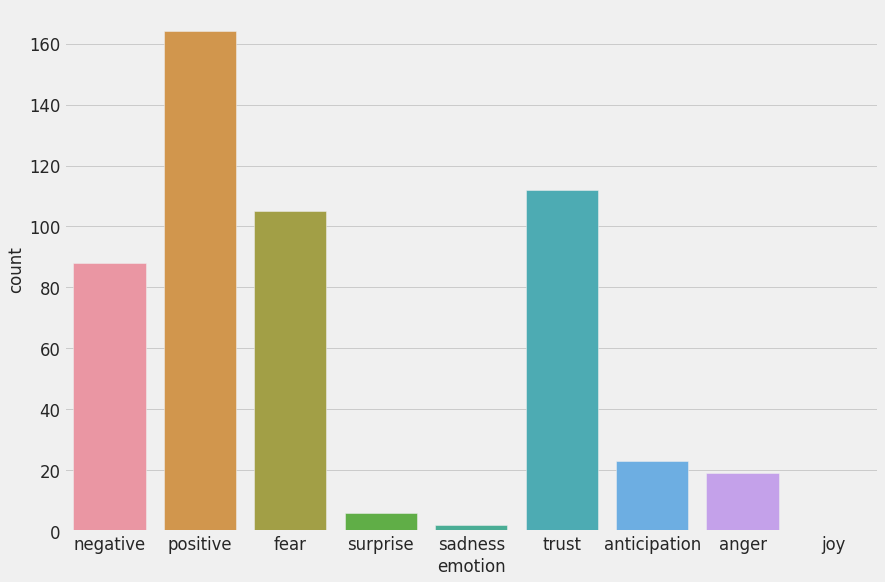


Cluster:  1




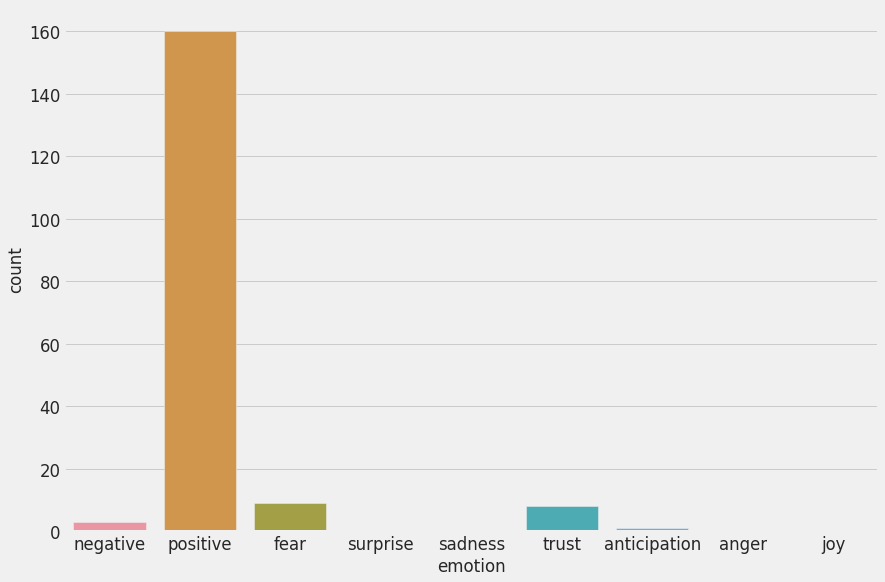


Cluster:  2




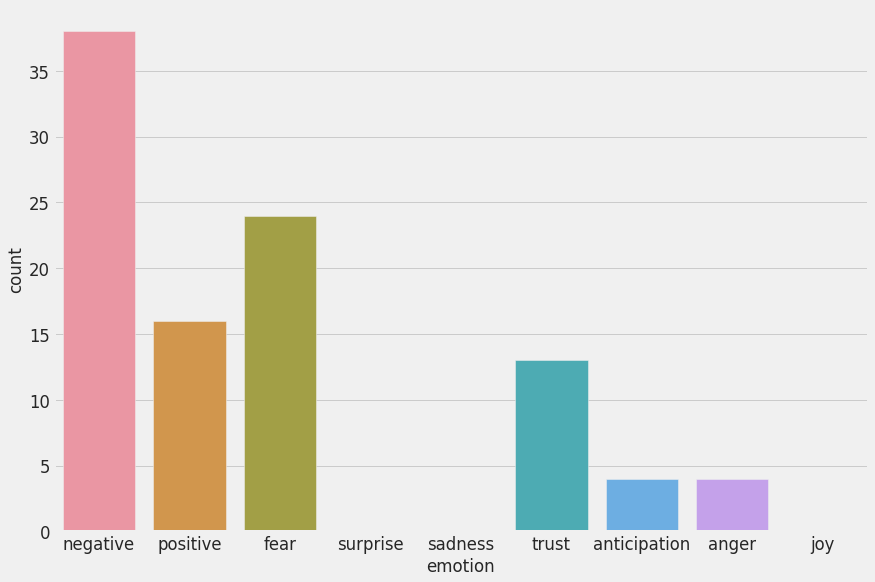


Cluster:  3




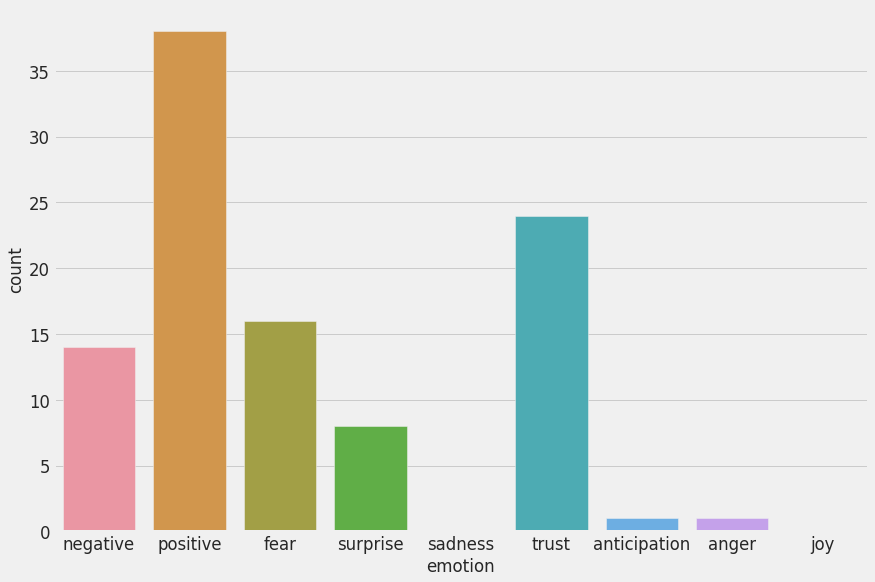


Cluster:  4




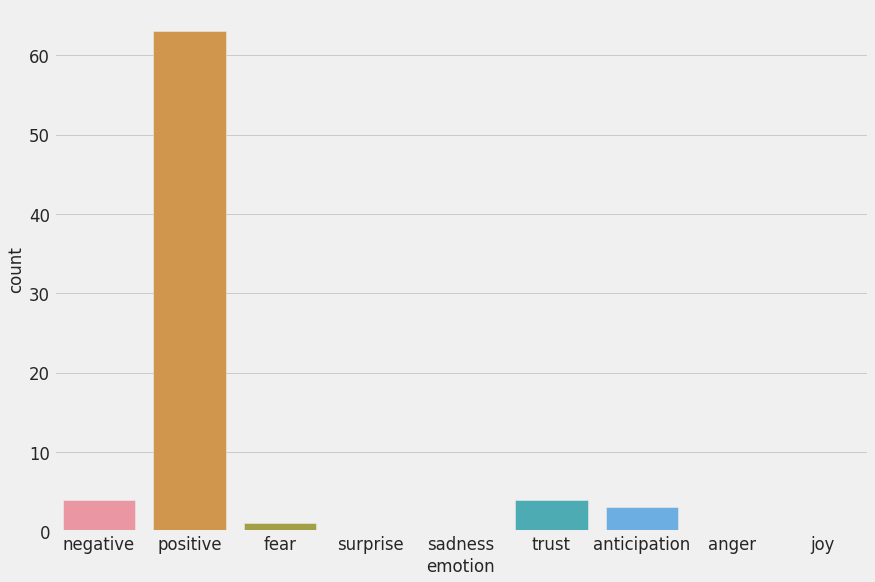


Cluster:  5




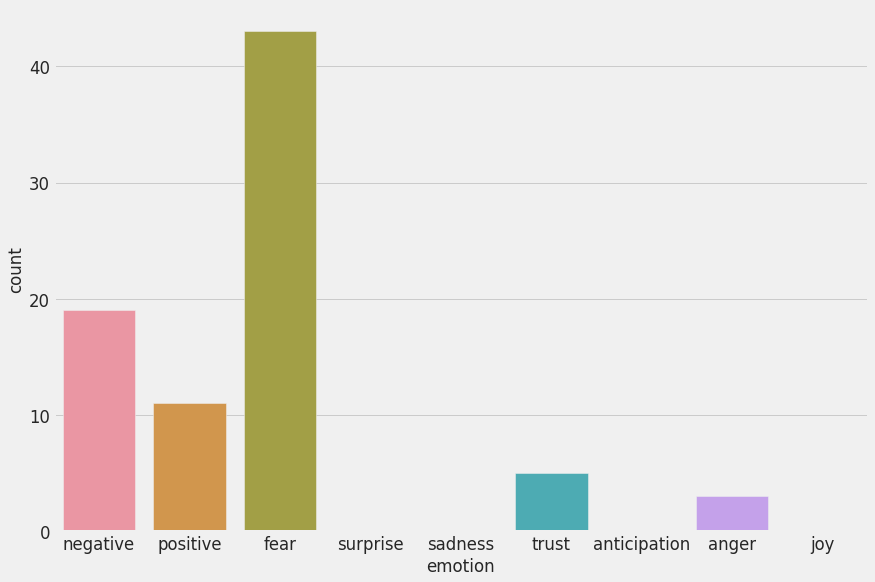


Cluster:  6




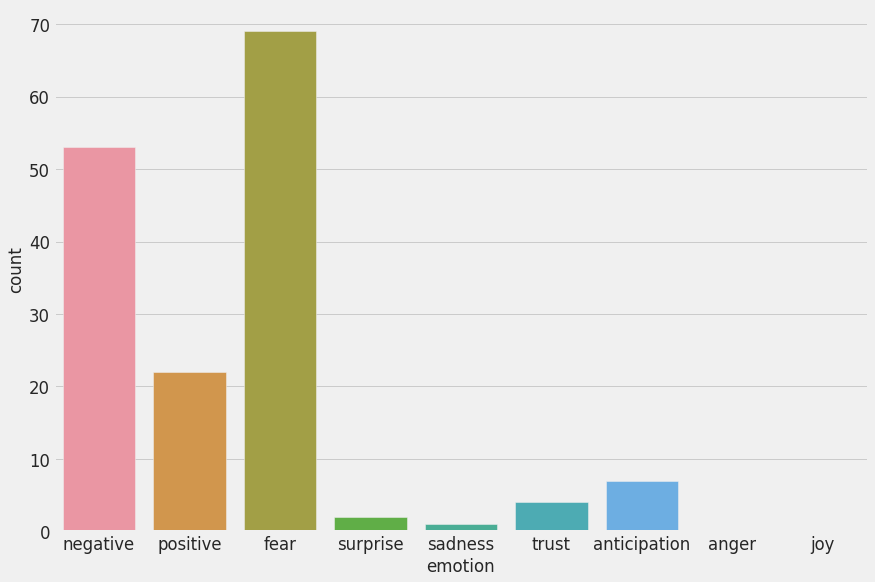


Cluster:  7




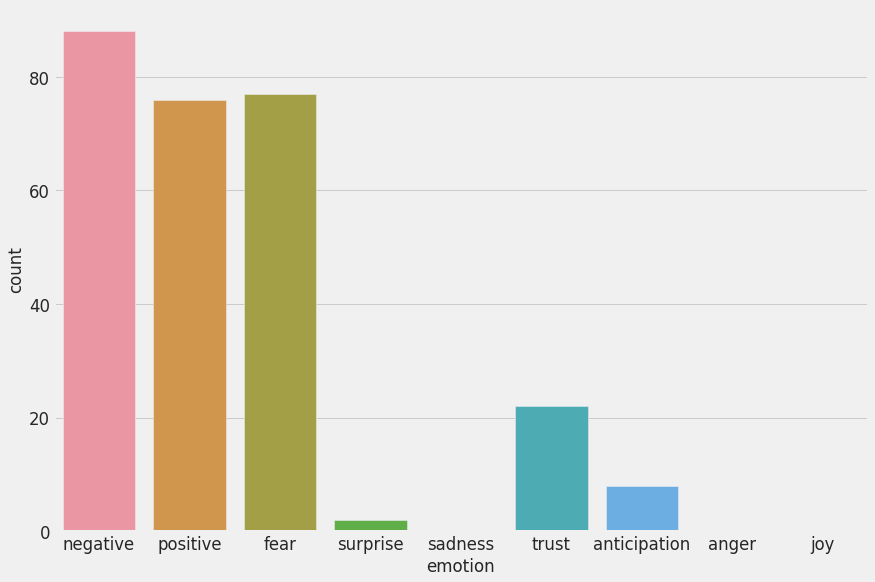


Cluster:  8




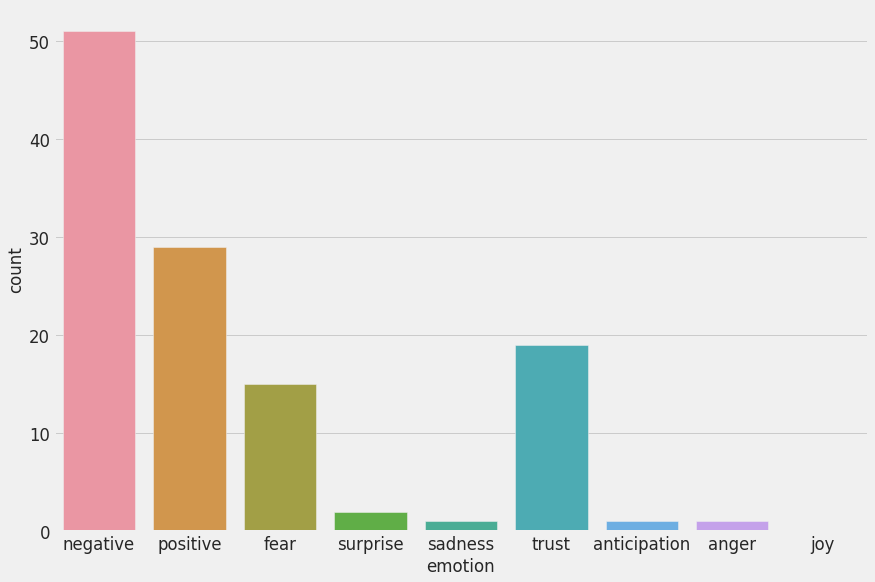

In [ ]:
for c in range (0,num_clusters):
  df=corona_data[corona_data['cluster']==c]
  print("\nCluster: ",c)
  print("\n")
  ax = sns.countplot(x= 'emotion',data=df,order=['negative', 'positive', 'fear', 'surprise', 'sadness','trust','anticipation','anger', 'joy'])
  
  plt.show()

# INSPECT CLUSTER 6

In [ ]:
df = corona_data[corona_data['cluster']==6]

In [ ]:
df.shape

(158, 15)

In [ ]:
vectorizer = TfidfVectorizer(stop_words=stopwords_eng, 
max_features= 1000, # keep top 1000 terms
max_df=0.3, 
min_df = 30, 
smooth_idf=True,
use_idf = True,
ngram_range=(1,2))

#vectorizer = TfidfVectorizer(use_idf = True, ngram_range=(1,2))

 
X = vectorizer.fit_transform(df['lemmatized_string'])
terms = vectorizer.get_feature_names()

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['view'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [ ]:
#elbow method
'''distortions = []
K = range(50,70)
for k in K:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()'''

"distortions = []\nK = range(50,70)\nfor k in K:\n    km = KMeans(n_clusters=k)\n    km.fit(X)\n    distortions.append(km.inertia_)\n\nplt.figure(figsize=(16,8))\nplt.plot(K, distortions, 'bx-')\nplt.xlabel('k')\nplt.ylabel('Distortion')\nplt.title('The Elbow Method showing the optimal k')\nplt.show()"

In [ ]:
num_clusters = 7

In [ ]:
km = KMeans(n_clusters=num_clusters,init='k-means++', max_iter=100, n_init=10, random_state=1)

labels = km.fit_predict(X)

In [ ]:
#most important n-gramms (words) in each cluster

print("K-means clustering: \n")
asc_order_centroids = km.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s,' % terms[ind])
    print('\n')

K-means clustering: 

Cluster 0:
 rise,
 surge,
 week,
 said,
 number,
 live,
 death,
 daily,
 coronavirus case,


Cluster 1:
 coronavirus case,
 rise,
 death,
 week,
 surge,
 said,
 number,
 live,
 daily,


Cluster 2:
 surge,
 coronavirus case,
 said,
 death,
 live,
 week,
 rise,
 number,
 daily,


Cluster 3:
 death,
 said,
 live,
 daily,
 rise,
 surge,
 number,
 week,
 coronavirus case,


Cluster 4:
 daily,
 rise,
 death,
 coronavirus case,
 number,
 surge,
 said,
 week,
 live,


Cluster 5:
 number,
 surge,
 death,
 coronavirus case,
 live,
 daily,
 week,
 said,
 rise,


Cluster 6:
 week,
 surge,
 rise,
 coronavirus case,
 live,
 number,
 daily,
 death,
 said,




In [ ]:
df['subcluster'] = labels

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


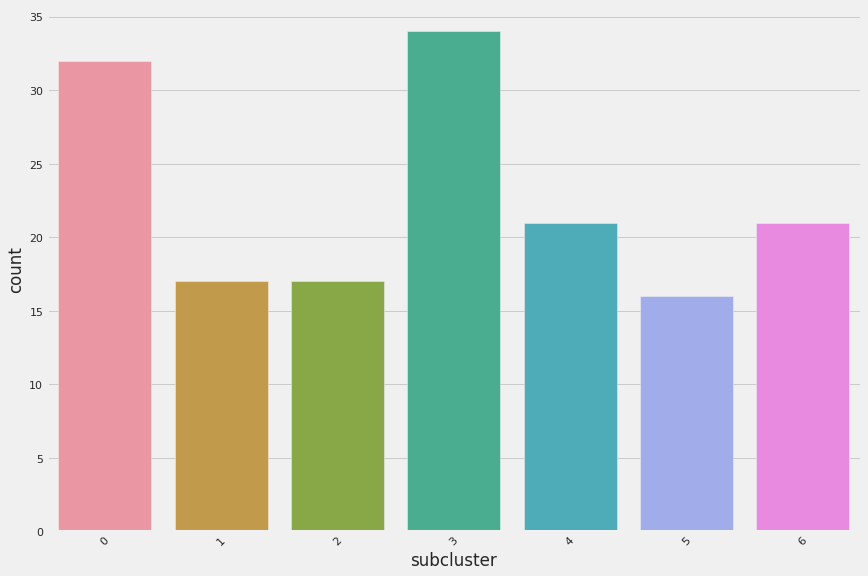

In [ ]:
sns.set(rc={'figure.figsize':(13,9)})
plt.style.use('fivethirtyeight')
ax = sns.countplot(x='subcluster', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

##LDA

https://towardsdatascience.com/the-complete-guide-for-topics-extraction-in-python-a6aaa6cedbbc


https://github.com/FelixChop/MediumArticles/blob/master/LDA-BBC.ipynb

LDA (Latent Dirichlet Allocation) is another method to discover hidden topics in documents.

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X);

for i,topic in enumerate(lda.components_):
    print(f'Topic #{i}:')
    print([terms[i] for i in topic.argsort()[-10:]])
    print('\n')


Topic #0:
['said', 'rise', 'week', 'surge', 'coronavirus case', 'live', 'daily', 'death', 'number']


Topic #1:
['coronavirus case', 'surge', 'week', 'number', 'rise', 'daily', 'said', 'death', 'live']


Topic #2:
['number', 'death', 'live', 'week', 'surge', 'said', 'daily', 'coronavirus case', 'rise']


Topic #3:
['number', 'rise', 'said', 'live', 'daily', 'death', 'coronavirus case', 'week', 'surge']


Topic #4:
['said', 'week', 'live', 'number', 'surge', 'rise', 'coronavirus case', 'daily', 'death']


Topic #5:
['said', 'number', 'death', 'coronavirus case', 'live', 'daily', 'rise', 'surge', 'week']


Topic #6:
['live', 'said', 'surge', 'coronavirus case', 'number', 'week', 'death', 'rise', 'daily']


Topic #7:
['week', 'rise', 'number', 'coronavirus case', 'daily', 'surge', 'death', 'live', 'said']


Topic #8:
['rise', 'surge', 'live', 'said', 'coronavirus case', 'week', 'number', 'daily', 'death']


Topic #9:
['rise', 'live', 'said', 'week', 'death', 'number', 'daily', 'surge', 'c